# Implementing Dubins Curves
This notebook is intended for testing different libraries or formulations for Dubins curve type path sets to be used for simulation and field planning work in an adaptive sampling/informative path planning regime.

Please note, that you may need to install the following in order to play with the [dubins library](https://github.com/AndrewWalker/Dubins-Curves):

```pip install dubins```

This library allows for the generation of dubins curves assuming that the turning radius is known. It also provides sample points along the curve given some sampling step.


In [1]:
# Necessary Imports
import dubins
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Learning the Dubins Library
The dubins library used here is a cython wrapper for a more powerful C++ library. The methods relevant to our implementation are demonstrated and documented inline below.

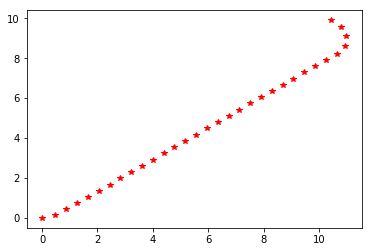

In [5]:
# Generating the shortest path; the library internally cycles through different dubins curve paths to select the
# shortest length path.

#starting location (x,y,yaw)
q0 = (0, 0, 0)

#goal location (x,y,yaw)
q1 = (10, 10, 3.14)

#radius of feasible turn
turning_radius = 1.0

#sampling "rate" or distance
step_size = 0.5

#find the shortest path, returns a dubins object
path = dubins.shortest_path(q0, q1, turning_radius)

#sample the path and return the points along the path
#methods to apply on the path include sample_many and sample
configurations, _ = path.sample_many(step_size)

#plot the path
x = []
y = []
for sample_points in configurations:
    x.append(sample_points[0])
    y.append(sample_points[1])
plt.plot(x,y,'r*')

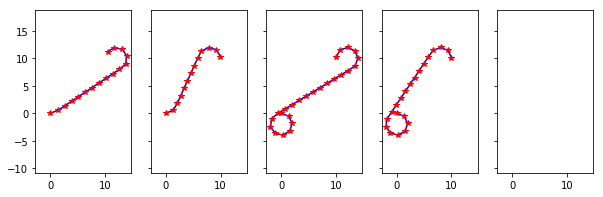

In [3]:
# Generating any path from a set of options. The options, documented below are referred to as "words" and consist of
# different turning options (3 segments are connected, segments are either left turn, straight, or right turn).

# Words: LSL = 0, LSR = 1, RSL = 2, RSR = 3, RLR = 4, LRL = 5
words = [0,1,2,3,4,5]

#starting location (x,y,yaw)
q0 = (0, 0, 0)

#goal location (x,y,yaw)
q1 = (10, 10, -1.57)

#radius of feasible turn
turning_radius = 2.0

#sampling "rate" or distance
step_size = 1.5

fig,ax = plt.subplots(1,5,sharex=True,sharey=True)
fig.set_size_inches(10,3)

#generate a figure for each of the options
for a,word in zip(ax,words):
    path = dubins.path(q0, q1, turning_radius, word)
    # Note! If a path is not feasible, path will be a Nonetype object, which will need to be handled
    if path != None:
        configurations, _ = path.sample_many(step_size)
        configurations = np.array(configurations)
        a.axis('equal')
        a.plot(configurations[:,0], configurations[:,1], 'b-')
        a.plot(configurations[:,0], configurations[:,1], 'r*')
        
plt.show()

## Making our Own Path Set Class

The interface for the dubins curve library is nice, but not quite ready in this form factor to interface with our system. We will now create three different path generation classes: Path_Generator, Dubins_Path_Generator, and Dubins_EqualPath_Generator.

**Path_Generator** creates the naive point to point connections from one point to another.

**Dubins_Path_Generator** create point-to-point connections, but calls upon the dubins library to generate paths.

**Dubins_EqualPath_Generator** controls for the number of sample points along the dubins trajectories so that all trajectories have the same number of samples available. This is useful if we would like to control for the number of points along a curve to consider in information space.

All classes can be parameterized by selecting the number of paths to generate (frontier_size), the distance between the center point and the horizon (horizon_length), vehicle dynamics (turning_radius), and sampling rate (sample_step). The pose of the robot is provided at every timestep in order to generate the world-coordinate sensitive list of path sets.

In [101]:
'''The Path_Generator class which creates naive point-to-point straightline paths'''
class Path_Generator:    
    def __init__(self, frontier_size, horizon_length, turning_radius, sample_step, extent):
        ''' Initialize a path generator
        Input:
            frontier_size (int) the number of points on the frontier we should consider for navigation
            horizon_length (float) distance between the vehicle and the horizon to consider
            turning_radius (float) the feasible turning radius for the vehicle
            sample_step (float) the unit length along the path from which to draw a sample
            extent (list of floats) the world boundaries
        '''

        # the parameters for the dubin trajectory
        self.fs = frontier_size
        self.hl = horizon_length
        self.tr = turning_radius
        self.ss = sample_step
        self.extent = extent

        # Global variables
        self.goals = [] #The frontier coordinates
        self.samples = {} #The sample points which form the paths
        self.cp = (0,0,0) #The current pose of the vehicle

    def generate_frontier_points(self):
        '''From the frontier_size and horizon_length, generate the frontier points to goal'''
        angle = np.linspace(-2.35,2.35,self.fs) #fix the possibilities to 75% of the unit circle, ignoring points directly behind the vehicle
        goals = []
        for a in angle:
            x = self.hl*np.cos(self.cp[2]+a)+self.cp[0]
            if x >= self.extent[1]-3*self.tr:
                x = self.extent[1]-3*self.tr
                y = (x-self.cp[0])*np.sin(self.cp[2]+a)+self.cp[1]
            elif x <= self.extent[0]+3*self.tr:
                x = self.extent[0]+3*self.tr
                y = (x-self.cp[0])*np.sin(self.cp[2]+a)+self.cp[1]
            else:
                y = self.hl*np.sin(self.cp[2]+a)+self.cp[1]
                if y >= self.extent[3]-3*self.tr:
                    y = self.extent[3]-3*self.tr
                    x = (y-self.cp[1])*-np.cos(self.cp[2]+a)+self.cp[0]
                elif y <= self.extent[2]+3*self.tr:
                    y = self.extent[2]+3*self.tr
                    x = (y-self.cp[1])*-np.cos(self.cp[2]+a)+self.cp[0]
            p = self.cp[2]+a
            if np.linalg.norm([self.cp[0]-x, self.cp[1]-y]) <= 3*self.tr:
                pass
            elif x > self.extent[1]-3*self.tr or x < self.extent[0]+3*self.tr:
                pass
            elif y > self.extent[3]-3*self.tr or y < self.extent[2]+3*self.tr:
                pass
            else:
#                 print (x,y,p)
                goals.append((x,y,p))
        
        self.goals = goals
        return self.goals

    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        cp = np.array(self.cp)
        coords = {}
        for i,goal in enumerate(self.goals):
            g = np.array(goal)
            distance = np.sqrt((cp[0]-g[0])**2 + (cp[1]-g[1])**2)
            samples = int(round(distance/self.ss))

            # Don't include the start location but do include the end point
            for j in range(0,samples):
                x = cp[0]+((j+1)*self.ss)*np.cos(g[2])
                y = cp[1]+((j+1)*self.ss)*np.sin(g[2])
                a = g[2]
                try: 
                    coords[i].append((x,y,a))
                except:
                    coords[i] = []
                    coords[i].append((x,y,a))
        self.samples = coords
        return self.samples

    def get_path_set(self, current_pose):
        '''Primary interface for getting list of path sample points for evaluation
        Input:
            current_pose (tuple of x, y, z, a which are floats) current location of the robot in world coordinates
        Output:
            paths (dictionary of frontier keys and sample points)
        '''
        self.cp = current_pose
        self.generate_frontier_points()
        paths = self.make_sample_paths()
        return paths

    def get_frontier_points(self):
        ''' Method to access the goal points'''
        return self.goals

    def get_sample_points(self):
        return self.samples

(0.15000000000000002, 0.3137159878184177, 9.647368421052635)
(0.15000000000000002, 0.4858387428429182, 9.894736842105267)
(0.15000000000000002, 0.6375157218843859, 10.142105263157898)
(0.15000000000000002, 0.7595128696071771, 10.389473684210529)
(2.3897807642351188, 0.22409811969496765, 12.615789473684213)
(2.3260335303972193, 0.5886741878131839, 12.863157894736846)
(2.1749590876242273, 0.9265438846007921, 13.110526315789476)


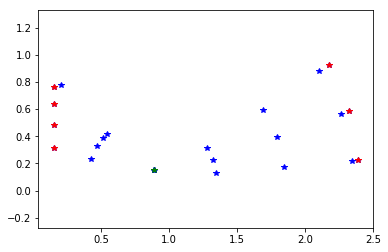

In [107]:
class Dubins_Path_Generator(Path_Generator):
    '''
    The Dubins_Path_Generator class, which inherits from the Path_Generator class. Replaces the make_sample_paths
    method with paths generated using the dubins library
    '''
    
    def buffered_paths(self):
        coords = {}
        for i,goal in enumerate(self.goals):            
            path = dubins.shortest_path(self.cp, goal, self.tr)
            configurations, _ = path.sample_many(self.ss)
            configurations.append(goal)
            temp = []
            for config in configurations:
                if config[0] > self.extent[0] and config[0] < self.extent[1] and config[1] > self.extent[2] and config[1] < self.extent[3]:
#                     print config
                    temp.append(config)
                else:
                    print 'here'
                    temp = []
                    break

            if len(temp) < 2:
                pass
            else:
                print temp[-1]
                coords[i] = temp
        return coords    
        
    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        coords = self.buffered_paths()
        
        if len(coords) == 0:
            print 'no viable path'
            
        self.samples = coords
        return coords

    
DPG = Dubins_Path_Generator(frontier_size=20, horizon_length=1.5, turning_radius=0.05, sample_step=0.5, extent=[0,10,0,10])
# s = DPG.get_path_set((9.8,9.8,np.pi/2))
s = DPG.get_path_set((0.8916120592296812, 0.15000000000000002, 10.760526315789477))


m = DPG.get_frontier_points()
m = np.array(m)
l = DPG.get_sample_points()

fig,ax = plt.subplots(1,1)
ax.axis('equal')
for key,val in l.items():
    f = np.array(val)
    plt.plot(f[:,0], f[:,1], 'b*')
    
plt.plot(m[:,0], m[:,1], 'r*')
plt.plot(DPG.cp[0], DPG.cp[1], 'g*')
plt.show()

In [6]:
class Dubins_EqualPath_Generator(Path_Generator):
    '''
    The Dubins_EqualPath_Generator class which inherits from Path_Generator. Modifies Dubin Curve paths so that all
    options have an equal number of sampling points
    '''
        
    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        coords = {}
        for i,goal in enumerate(self.goals):
            g = (goal[0],goal[1],self.cp[2])
            path = dubins.shortest_path(self.cp, goal, self.tr)
            configurations, _ = path.sample_many(self.ss)
            coords[i] = configurations
        
        # find the "shortest" path in sample space
        current_min = 1000
        for key,path in coords.items():
            if len(path) < current_min:
                current_min = len(path)
        
        # limit all paths to the shortest path in sample space
        for key,path in coords.items():
            if len(path) > current_min:
                path = path[0:current_min]
                coords[key]=path
        
        self.samples = coords
        return coords

DEPG = Dubins_EqualPath_Generator(frontier_size=6, horizon_length=5, turning_radius=1, sample_step=0.5)
s = DEPG.get_path_set((-10,-10,0))

m = DEPG.get_frontier_points()
m = np.array(m)
l = DEPG.get_sample_points()

fig,ax = plt.subplots(1,1)
ax.axis('equal')
for key,val in l.items():
    f = np.array(val)
    plt.plot(f[:,0], f[:,1], 'b*')
    
plt.plot(m[:,0], m[:,1], 'r*')
plt.show()

TypeError: __init__() takes exactly 6 arguments (5 given)